In [1]:
# he_index_main_dir = "/private6/Projects/Nothobranchius_furzeri/Code/Data/Index"
he_index_main_dir = "Data/Index"
notebook_title = "HEIndexAnalysis"
notebook_img = "https://upload.wikimedia.org/wikipedia/commons/2/22/Nothobranchius_furzeri_GRZ_thumb.jpg"
notebook_img_src = "https://de.wikipedia.org/wiki/Benutzer:Ugau"
groups_order = [
    "6.5-WT-Full-Male",
    "6.5-Het-Full-Male",
    "15-WT-Full-Male",
    "15-Het-Full-Male",

    "6.5-WT-Fasted-Male",
    "6.5-Het-Fasted-Male",
    "15-WT-Fasted-Male",
    "15-Het-Fasted-Male",

    "6.5-WT-Fasted-Female",
    "6.5-Het-Fasted-Female",
    "15-WT-Fasted-Female",
    "15-Het-Fasted-Female"
]

In [2]:
%cd ..

/private6/Projects/Nothobranchius_furzeri/Code


In [3]:
from IPython.display import display, Markdown, Image

In [4]:
display(Markdown(f"# **{notebook_title}**"))

# **HEIndexAnalysis**

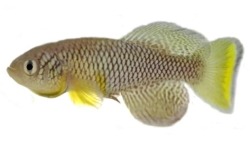

In [5]:
Image(notebook_img, width = 400, height = 250) if notebook_img else None

In [6]:
display(Markdown(f"[source]({notebook_img_src})")) if notebook_img and notebook_img_src else None

[source](https://de.wikipedia.org/wiki/Benutzer:Ugau)

### Imports

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from pathlib import Path
import sys

import pandas as pd
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
from scipy.stats import ranksums
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.dpi": 100, 
#             "savefig.dpi": 100, 
            "figure.autolayout": False
           })
dpi = 600
sns.set_context('notebook')
sns.set_style('white')
sns.set_style("ticks")

sys.path.append(str(Path(".")))
from Index.summarize_he_index_utils import optimize_signal_vs_snr, find_best_distance
from Index.summarize_he_index_utils import read_index_df
from EDA.stats_and_plots import groups_pairwise_comparisons, groups_pairwise_comparisons_2, independent_t_test, scatter_error_bar_plot
from EDA.pandas_utils import reorder_df_by_wanted_cols, define_groups_order
from EDA.plt_sns_utils import two_categories_box_pairs, statannot_plot
from Statannot.statannot import add_stat_annotation

### Paths

In [9]:
he_index_main_dir = Path(he_index_main_dir)
plots_out_dir = Path(he_index_main_dir, "HEIndexPlots")
plots_out_dir.mkdir(exist_ok=True)

## Optimizing Signal vs. SNR

In [10]:
signals_snrs_df = optimize_signal_vs_snr(he_index_main_dir)
signals_snrs_df

Distance    Signal     Noise    SNR  ActualSignal
0         0  1.677550  0.210087  88.87      1.467463
1        30  1.022719  0.206135  83.23      0.816584
2        60  0.795998  0.251380  76.00      0.544618
3        90  0.742455  0.239645  75.60      0.502810
4       120  0.681059  0.234047  74.42      0.447012

In [11]:
signals = signals_snrs_df["Signal"]
snrs = signals_snrs_df["SNR"]
distances = signals_snrs_df["Distance"]

In [12]:
best_signal, best_snr, best_distance = find_best_distance(signals, snrs, distances)
best_noise = signals_snrs_df.loc[signals_snrs_df["Distance"] == best_distance, "Noise"].values[0]

In [13]:
x_axis_name = "SNR"
y_axis_name = "Mean A2G Index"
head_title = "Signal vs. SNR of UE regions' indices  (regions extended by different number of BP from each side)"

width=1000
height=400

fig = go.Figure()
fig.add_trace(go.Scatter(x=snrs, y=signals, mode='lines+markers+text', text=distances, 
                         textposition="bottom center", textfont=dict(size=11), marker=dict(color="red")))
fig.add_trace(go.Scatter(x=[best_snr], y=[best_signal], mode='markers+text',
                        text=f"<b>Best: {best_distance} BP<b>", textfont=dict(size=13, color="black"), 
                         textposition="top right", marker=dict(color="black", size=7)))

fig.update_xaxes(title_text=x_axis_name, range=[max(snrs)+3, min(snrs)-3])
fig.update_yaxes(title_text=y_axis_name, range=[min(signals)-1, max(signals)+1.5])
fig.update_layout(title_text=head_title, title_x=0.5, height=height, width=width, template="simple_white")
fig.update(layout_showlegend=False)

existing_plots = len(list(plots_out_dir.iterdir()))
fig.write_image(Path(plots_out_dir, f"{existing_plots + 1} {head_title}.svg"))

fig.show()

In [14]:
# create a file with the name of the best distance in he_index_main_dir

best_index_file_flag = Path(he_index_main_dir, f"BEST_{best_distance}_BP")
best_index_file_flag.touch(exist_ok=True)

In [15]:
display(Markdown(f"## Downstream analysis for distance = {best_distance}"))

## Downstream analysis for distance = 0

In [16]:
index_df_path = Path(he_index_main_dir, f"HEIndex{best_distance}", "EditingIndex.csv")
index_df = read_index_df(index_df_path)

index_df = index_df.sort_values("Sample").reset_index(drop=True)

index_df[["Age(weeks)", "Genotype", "Diet", "Sex"]] = index_df.loc[:, "Group"].str.split("-", expand=True)
first_cols = ["Sample", "Group", "Age(weeks)", "Genotype", "Diet", "Sex"]
index_df = reorder_df_by_wanted_cols(index_df, first_cols)

index_df

Sample                  Group Age(weeks) Genotype    Diet     Sex  \
0   sample11       15-Het-Full-Male         15      Het    Full    Male   
1   sample12       15-Het-Full-Male         15      Het    Full    Male   
2   sample13       15-Het-Full-Male         15      Het    Full    Male   
3   sample14       15-Het-Full-Male         15      Het    Full    Male   
4   sample15    15-WT-Fasted-Female         15       WT  Fasted  Female   
5   sample16    15-WT-Fasted-Female         15       WT  Fasted  Female   
6   sample17    15-WT-Fasted-Female         15       WT  Fasted  Female   
7   sample18      15-WT-Fasted-Male         15       WT  Fasted    Male   
8   sample19      15-WT-Fasted-Male         15       WT  Fasted    Male   
9   sample20      15-WT-Fasted-Male         15       WT  Fasted    Male   
10  sample21   15-Het-Fasted-Female         15      Het  Fasted  Female   
11  sample22   15-Het-Fasted-Female         15      Het  Fasted  Female   
12  sample23   15-Het-Fasted-Female         15      Het  Fasted  Female   
13  sample24   15-Het-Fasted-Female         15      Het  Fasted  Female   
14  sample25     15-Het-Fasted-Male         15      Het  Fasted    Male   
15  sample26     15-Het-Fasted-Male         15      Het  Fasted    Male   
16  sample27     15-Het-Fasted-Male         15      Het  Fasted    Male   
17  sample28   6.5-WT-Fasted-Female        6.5       WT  Fasted  Female   
18  sample29   6.5-WT-Fasted-Female        6.5       WT  Fasted  Female   
19  sample30   6.5-WT-Fasted-Female        6.5       WT  Fasted  Female   
20  sample31     6.5-WT-Fasted-Male        6.5       WT  Fasted    Male   
21  sample32     6.5-WT-Fasted-Male        6.5       WT  Fasted    Male   
22  sample33     6.5-WT-Fasted-Male        6.5       WT  Fasted    Male   
23  sample34  6.5-Het-Fasted-Female        6.5      Het  Fasted  Female   
24  sample35  6.5-Het-Fasted-Female        6.5      Het  Fasted  Female   
25  sample36  6.5-Het-Fasted-Female        6.5      Het  Fasted  Female   
26  sample37  6.5-Het-Fasted-Female        6.5      Het  Fasted  Female   
27  sample38    6.5-Het-Fasted-Male        6.5      Het  Fasted    Male   
28  sample39    6.5-Het-Fasted-Male        6.5      Het  Fasted    Male   
29   sample4        15-WT-Full-Male         15       WT    Full    Male   
30  sample40    6.5-Het-Fasted-Male        6.5      Het  Fasted    Male   
31  sample41    6.5-Het-Fasted-Male        6.5      Het  Fasted    Male   
32  sample45       6.5-WT-Full-Male        6.5       WT    Full    Male   
33  sample46       6.5-WT-Full-Male        6.5       WT    Full    Male   
34  sample47       6.5-WT-Full-Male        6.5       WT    Full    Male   
35   sample5        15-WT-Full-Male         15       WT    Full    Male   
36  sample52      6.5-Het-Full-Male        6.5      Het    Full    Male   
37  sample53      6.5-Het-Full-Male        6.5      Het    Full    Male   
38  sample54      6.5-Het-Full-Male        6.5      Het    Full    Male   
39  sample55      6.5-Het-Full-Male        6.5      Het    Full    Male   
40   sample6        15-WT-Full-Male         15       WT    Full    Male   

    A2CEditingIndex  A2GEditingIndex  A2TEditingIndex  C2AEditingIndex  \
0          0.054664         1.681028         0.098369         0.069953   
1          0.056180         1.597723         0.099210         0.069082   
2          0.056090         1.924022         0.101463         0.072707   
3          0.053077         1.529676         0.096509         0.064188   
4          0.059342         1.515568         0.106698         0.072325   
5          0.066952         1.444567         0.111484         0.074529   
6          0.062111         1.463507         0.114352         0.070020   
7          0.072704         2.174825         0.101011         0.076422   
8          0.067092         1.781089         0.101848         0.070499   
9          0.059475         1.697496         0.101037         0.070147   
10         0.065710         1.496796     

### Overall Impression

In [17]:
indices_cols = [col for col in index_df.columns if col.endswith("EditingIndex")]
indices_dfs = []
for col in indices_cols:
    df = index_df.loc[:, ["Sample", "Group", "Age(weeks)", "Genotype", "Diet", "Sex", col]]
    df = df.rename(columns={col: "Index"})
    df["Mismatch"] = col[:3]
    indices_dfs.append(df)
signal_noise_df = pd.concat(indices_dfs)
signal_noise_df

Sample                Group Age(weeks) Genotype    Diet     Sex  \
0   sample11     15-Het-Full-Male         15      Het    Full    Male   
1   sample12     15-Het-Full-Male         15      Het    Full    Male   
2   sample13     15-Het-Full-Male         15      Het    Full    Male   
3   sample14     15-Het-Full-Male         15      Het    Full    Male   
4   sample15  15-WT-Fasted-Female         15       WT  Fasted  Female   
..       ...                  ...        ...      ...     ...     ...   
36  sample52    6.5-Het-Full-Male        6.5      Het    Full    Male   
37  sample53    6.5-Het-Full-Male        6.5      Het    Full    Male   
38  sample54    6.5-Het-Full-Male        6.5      Het    Full    Male   
39  sample55    6.5-Het-Full-Male        6.5      Het    Full    Male   
40   sample6      15-WT-Full-Male         15       WT    Full    Male   

       Index Mismatch  
0   0.054664      A2C  
1   0.056180      A2C  
2   0.056090      A2C  
3   0.053077      A2C  
4   0.059342      A2C  
..       ...      ...  
36  0.177161      C2T  
37  0.193984      C2T  
38  0.191992      C2T  
39  0.185774      C2T  
40  0.182361      C2T  

[246 rows x 8 columns]

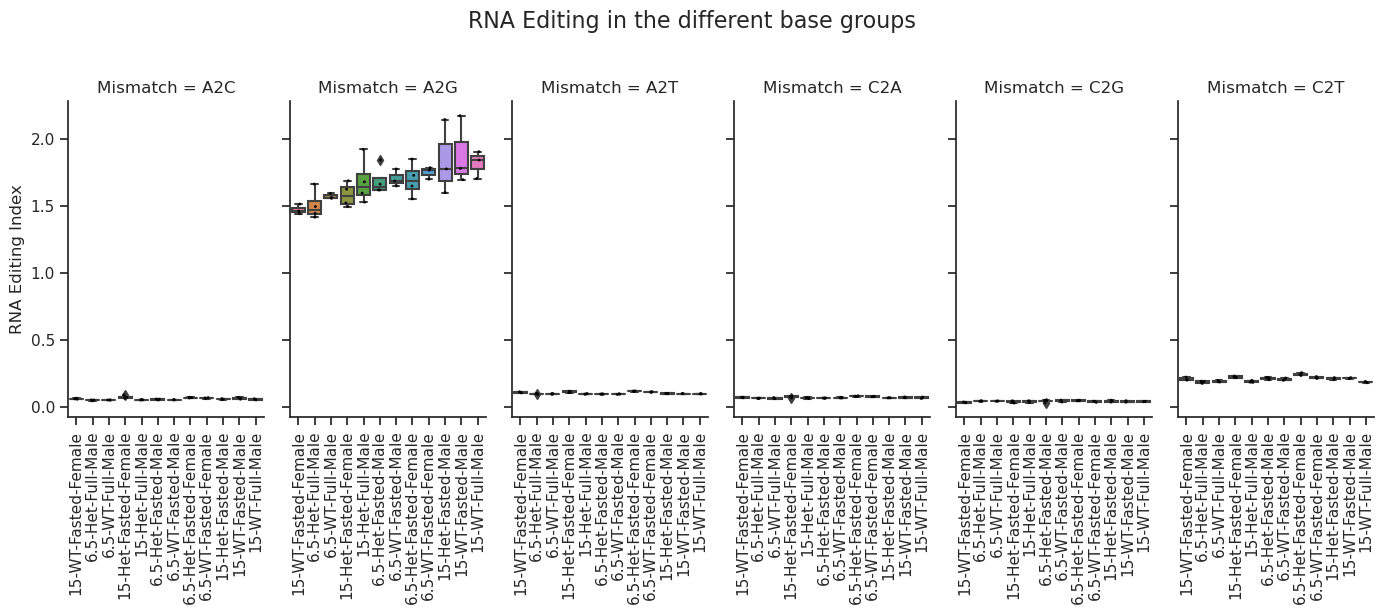

In [18]:
a2g_df = signal_noise_df.loc[signal_noise_df["Mismatch"] == "A2G"]
groups_order = define_groups_order(a2g_df, group_col="Group", signal_col="Index")

head_title = "RNA Editing in the different base groups"
g = sns.FacetGrid(signal_noise_df, col="Mismatch", aspect=1.4)
g.map(sns.boxplot, "Group", "Index", order=groups_order, palette=sns.color_palette("husl", len(groups_order)))
g.map(sns.stripplot, "Group", "Index", order=groups_order, color="black", jitter=True, size=2)
g.fig.suptitle(head_title, x=0.5, y=1.02, fontsize=16)
g.set_axis_labels("", "RNA Editing Index")
g.fig.subplots_adjust(wspace=0.1)
g.set_xticklabels(rotation=90)
width, length = 14, 6
g.fig.set_size_inches(width, length)
g.tight_layout()
existing_plots = len(list(plots_out_dir.iterdir()))
g.savefig(Path(plots_out_dir, f"{existing_plots + 1} {head_title}.svg"), 
#           dpi=dpi
         )

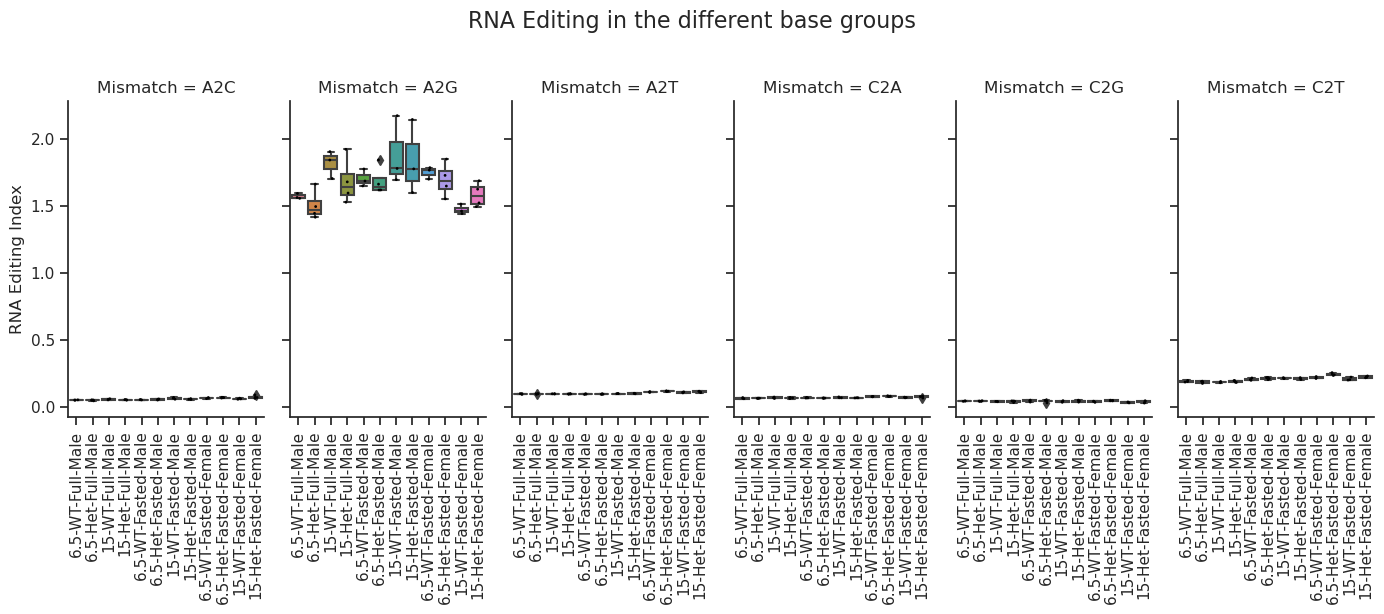

In [19]:
a2g_df = signal_noise_df.loc[signal_noise_df["Mismatch"] == "A2G"]
groups_order = [
    "6.5-WT-Full-Male",
    "6.5-Het-Full-Male",
    "15-WT-Full-Male",
    "15-Het-Full-Male",

    "6.5-WT-Fasted-Male",
    "6.5-Het-Fasted-Male",
    "15-WT-Fasted-Male",
    "15-Het-Fasted-Male",

    "6.5-WT-Fasted-Female",
    "6.5-Het-Fasted-Female",
    "15-WT-Fasted-Female",
    "15-Het-Fasted-Female"
]

head_title = "RNA Editing in the different base groups"
g = sns.FacetGrid(signal_noise_df, col="Mismatch", aspect=1.4)
g.map(sns.boxplot, "Group", "Index", order=groups_order, palette=sns.color_palette("husl", len(groups_order)))
g.map(sns.stripplot, "Group", "Index", order=groups_order, color="black", jitter=True, size=2)
g.fig.suptitle(head_title, x=0.5, y=1.02, fontsize=16)
g.set_axis_labels("", "RNA Editing Index")
g.fig.subplots_adjust(wspace=0.1)
g.set_xticklabels(rotation=90)
width, length = 14, 6
g.fig.set_size_inches(width, length)
g.tight_layout()
existing_plots = len(list(plots_out_dir.iterdir()))
g.savefig(Path(plots_out_dir, f"{existing_plots + 1} {head_title}.svg"), 
#           dpi=dpi
         )

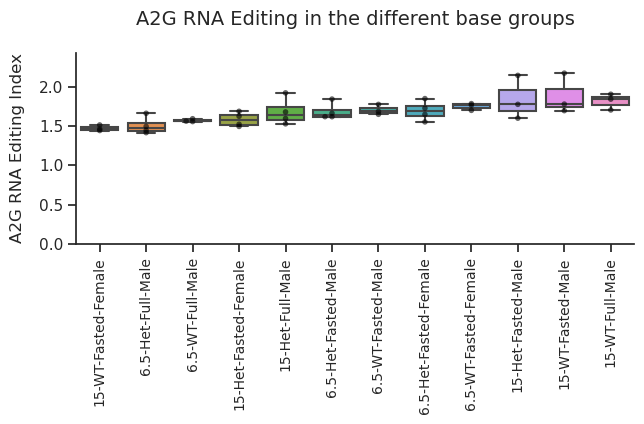

In [20]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G")]
x = "Group"
y = "Index"
x_order = define_groups_order(df, group_col=x, signal_col=y)
main_title = "A2G RNA Editing in the different base groups"
ylabel = "A2G RNA Editing Index"
xlabel = ""
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel, xlabel=xlabel,
               xticklabels_rotation=90, xticklabels_fontsize=10,
               outer_test=None, points_plot_size=4,
               plots_out_dir=plots_out_dir, dpi=dpi)

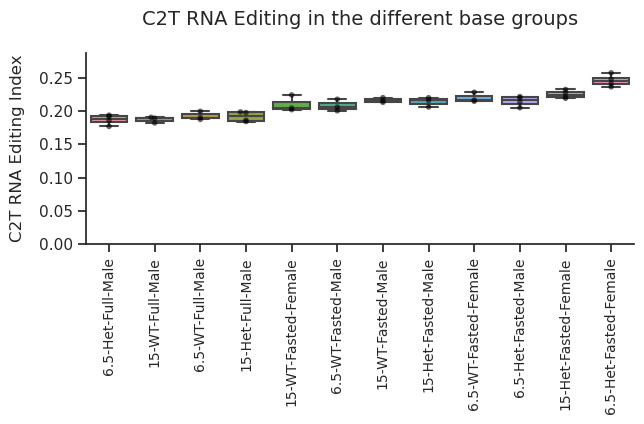

In [21]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "C2T")]
x = "Group"
y = "Index"
x_order = define_groups_order(df, group_col=x, signal_col=y)
main_title = "C2T RNA Editing in the different base groups"
ylabel = "C2T RNA Editing Index"
xlabel = ""
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel, xlabel=xlabel,
               xticklabels_rotation=90, xticklabels_fontsize=10, outer_test=None, points_plot_size=4,
               plots_out_dir=plots_out_dir, dpi=dpi)

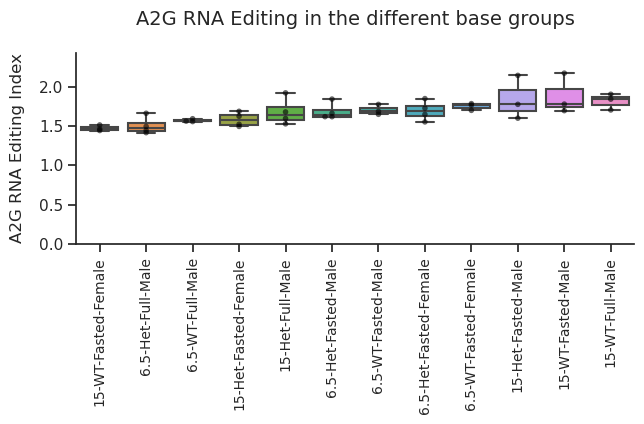

In [22]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G")]
x = "Group"
y = "Index"
x_order = define_groups_order(df, group_col=x, signal_col=y)
main_title = "A2G RNA Editing in the different base groups"
ylabel = "A2G RNA Editing Index"
xlabel = ""
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel, xlabel=xlabel,
               xticklabels_rotation=90, xticklabels_fontsize=10, points_plot_size=4,
               plots_out_dir=plots_out_dir, dpi=dpi)

Pairwise **independent t-tests** for **A2G Indices**, followed by **BH correction**:

In [23]:
a2g_df = signal_noise_df.loc[signal_noise_df["Mismatch"] == "A2G"]
styled_corrected_p_values_df, *_ = groups_pairwise_comparisons_2(a2g_df, "Group", "Index", "Sample")
print("\n(Significant p-values after BH correction are shown in red)\n")
styled_corrected_p_values_df


(Significant p-values after BH correction are shown in red)



Pairwise **independent t-tests** for **C2T Indices**, followed by **BH correction**:

In [24]:
c2t_df = signal_noise_df.loc[signal_noise_df["Mismatch"] == "C2T"]
styled_corrected_p_values_df, *_ = groups_pairwise_comparisons_2(c2t_df, "Group", "Index", "Sample")
print("\n(Significant p-values after BH correction are shown in red)\n")
styled_corrected_p_values_df


(Significant p-values after BH correction are shown in red)



### Sex

In [25]:
df = signal_noise_df.loc[signal_noise_df["Mismatch"]=="A2G"]
df["Sex"].count()

41

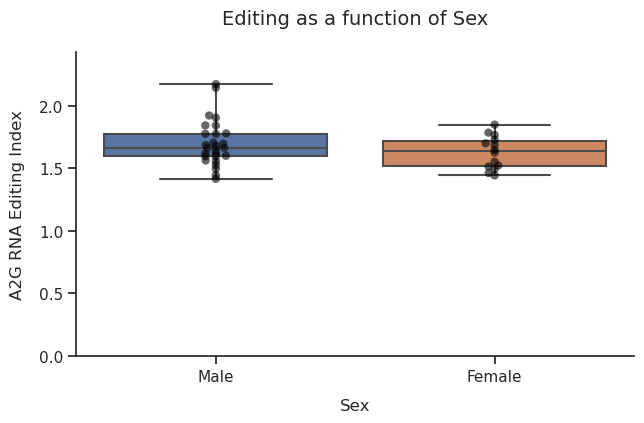

In [26]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G")]
x = "Sex"
y = "Index"
# x_order = ["Female", "Male"]
x_order = ["Male", "Female"]
main_title = "Editing as a function of Sex"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Male v.s. Female: Custom statistical test, P_val:0.000e+00



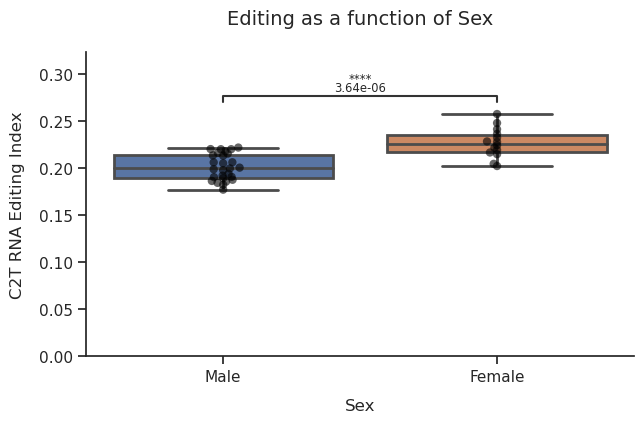

In [27]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "C2T")]
x = "Sex"
y = "Index"
# x_order = ["Female", "Male"]
x_order = ["Male", "Female"]
main_title = "Editing as a function of Sex"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

### Age

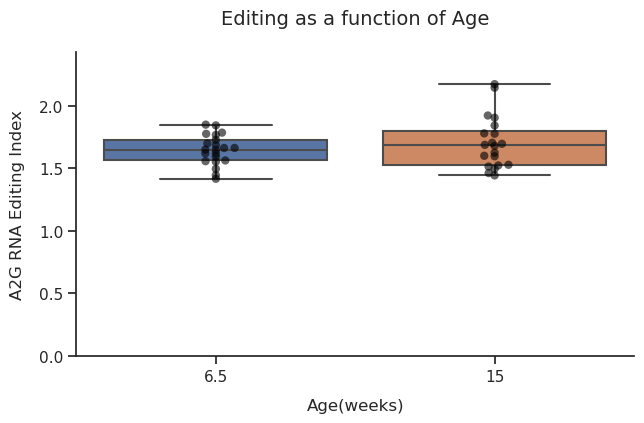

In [28]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

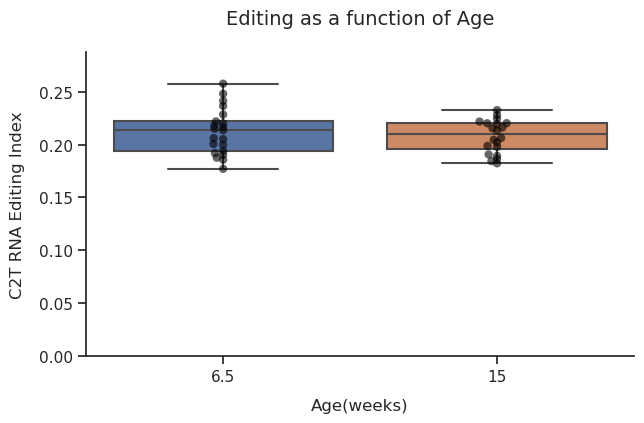

In [29]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "C2T")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing as a function of Age"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

### Genotype

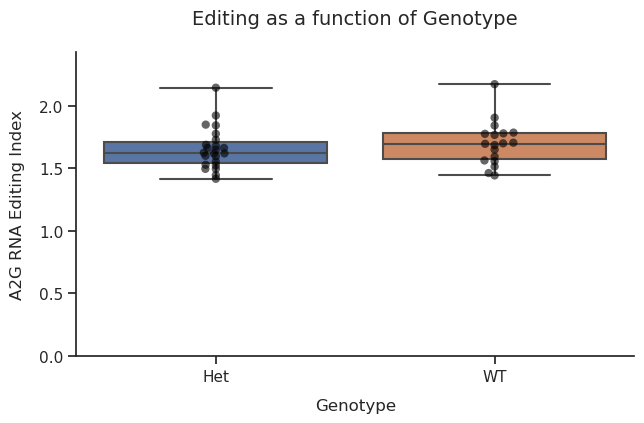

In [30]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G")]
x = "Genotype"
y = "Index"
x_order = ["Het", "WT"]
main_title = "Editing as a function of Genotype"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

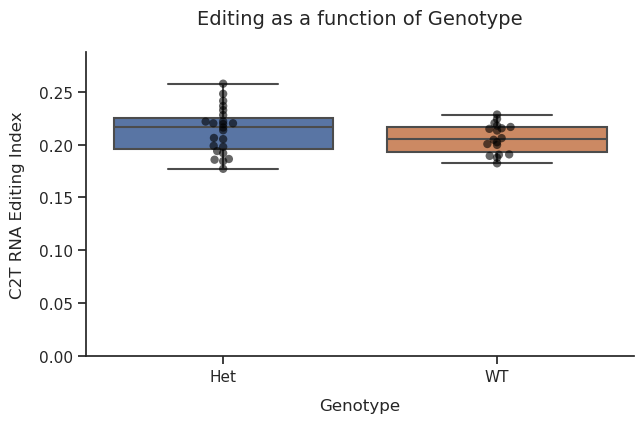

In [31]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "C2T")]
x = "Genotype"
y = "Index"
x_order = ["Het", "WT"]
main_title = "Editing as a function of Genotype"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

### Diet

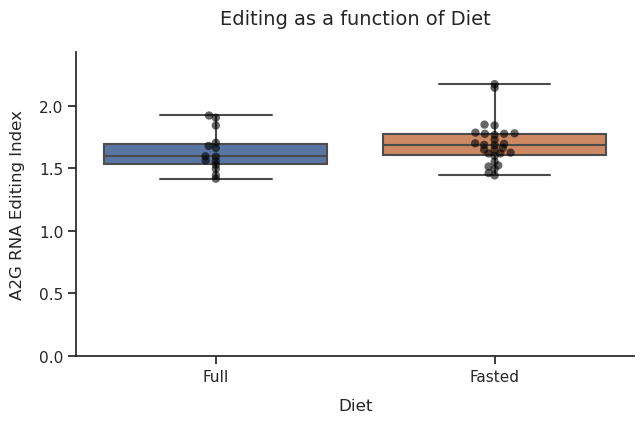

In [32]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G")]
x = "Diet"
y = "Index"
x_order = ["Full", "Fasted"]
main_title = f"Editing as a function of {x}"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Full v.s. Fasted: Custom statistical test, P_val:0.000e+00



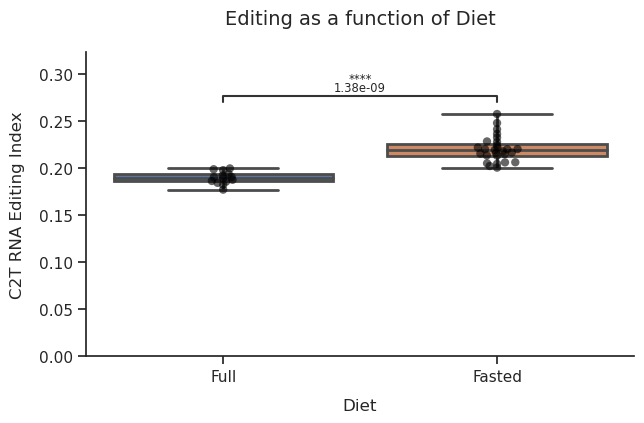

In [33]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "C2T")]
x = "Diet"
y = "Index"
x_order = ["Full", "Fasted"]
main_title = f"Editing as a function of {x}"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y, x_order=x_order, 
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

### Males: Diet

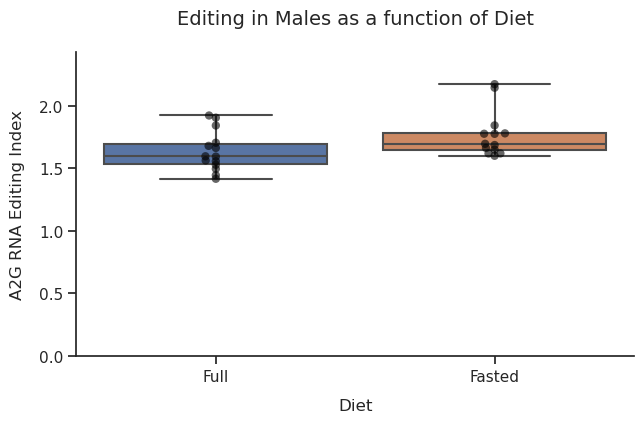

In [34]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Male")]
x = "Diet"
y = "Index"
x_order = ["Full", "Fasted"]
main_title = "Editing in Males as a function of Diet"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Full v.s. Fasted: Custom statistical test, P_val:0.000e+00



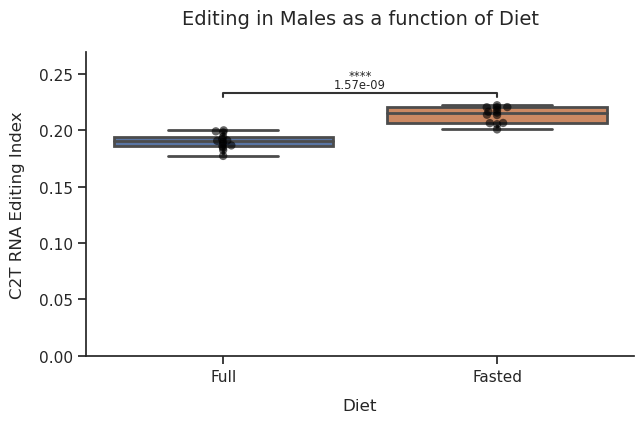

In [35]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="C2T") & 
                         (signal_noise_df["Sex"]=="Male")]
x = "Diet"
y = "Index"
x_order = ["Full", "Fasted"]
main_title = "Editing in Males as a function of Diet"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

### Sex & Age

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Female_6.5 v.s. Female_15: Custom statistical test, P_val:0.000e+00
Male_6.5 v.s. Male_15: Custom statistical test, P_val:0.000e+00
Male_15 v.s. Female_6.5: Custom statistical test, P_val:0.000e+00
Male_15 v.s. Female_15: Custom statistical test, P_val:0.000e+00
Male_6.5 v.s. Female_6.5: Custom statistical test, P_val:0.000e+00
Male_6.5 v.s. Female_15: Custom statistical test, P_val:0.000e+00



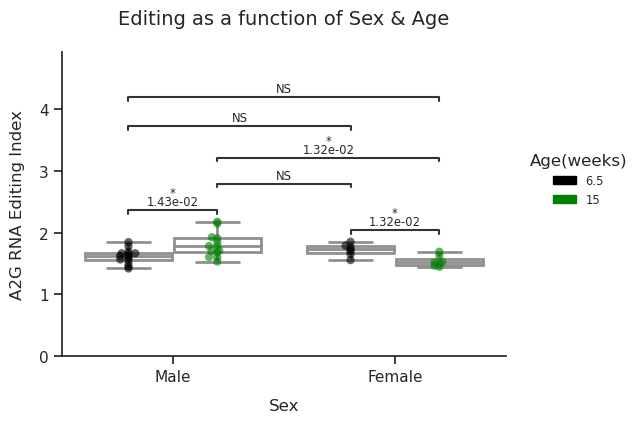

In [36]:
df = signal_noise_df.loc[signal_noise_df["Mismatch"] == "A2G"]
x = "Sex"
hue = "Age(weeks)"
y = "Index"
# x_order = ["Female", "Male"]
x_order = ["Male", "Female"]
hue_order = ["6.5", "15"]
main_title = f"Editing as a function of {x} & Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True,
               base_plot_color="white",
               points_plot_size=4,
               points_plot_pallete=["black", "green"],
            #    legend_loc="best",
            #    legend_frameon=False
               )

In [37]:
signal = "A2G"
noise = "C2T"
mismatches = [signal, noise]
sex_age_snr_df = (signal_noise_df.
                  assign(SexAge=signal_noise_df["Sex"]+"-"+signal_noise_df["Age(weeks)"]).
                  assign(Sample=lambda x: x["Sample"].str.lstrip("sample")).
                  rename(columns={"SexAge": "Sex-Age(weeks)"})
                 )
sex_age_snr_df = sex_age_snr_df.loc[sex_age_snr_df["Mismatch"].isin(mismatches)]
sex_age_snr_df

Sample                Group Age(weeks) Genotype    Diet     Sex     Index  \
0      11     15-Het-Full-Male         15      Het    Full    Male  1.681028   
1      12     15-Het-Full-Male         15      Het    Full    Male  1.597723   
2      13     15-Het-Full-Male         15      Het    Full    Male  1.924022   
3      14     15-Het-Full-Male         15      Het    Full    Male  1.529676   
4      15  15-WT-Fasted-Female         15       WT  Fasted  Female  1.515568   
..    ...                  ...        ...      ...     ...     ...       ...   
36     52    6.5-Het-Full-Male        6.5      Het    Full    Male  0.177161   
37     53    6.5-Het-Full-Male        6.5      Het    Full    Male  0.193984   
38     54    6.5-Het-Full-Male        6.5      Het    Full    Male  0.191992   
39     55    6.5-Het-Full-Male        6.5      Het    Full    Male  0.185774   
40      6      15-WT-Full-Male         15       WT    Full    Male  0.182361   

   Mismatch Sex-Age(weeks)  
0       A2G        Male-15  
1       A2G        Male-15  
2       A2G        Male-15  
3       A2G        Male-15  
4       A2G      Female-15  
..      ...            ...  
36      C2T       Male-6.5  
37      C2T       Male-6.5  
38      C2T       Male-6.5  
39      C2T       Male-6.5  
40      C2T        Male-15  

[82 rows x 9 columns]

### Sex & Genotype

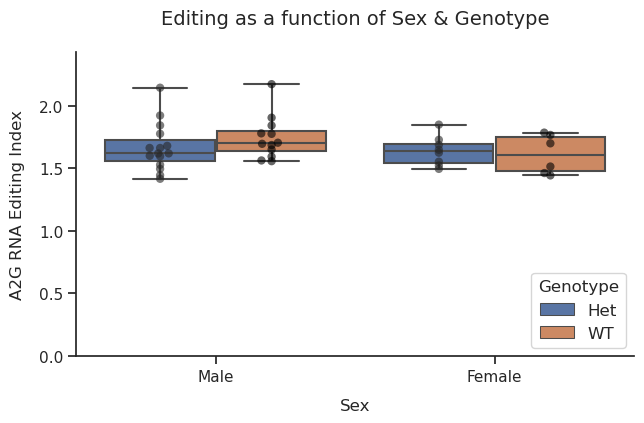

In [45]:
df = signal_noise_df.loc[signal_noise_df["Mismatch"] == "A2G"]
x = "Sex"
hue = "Genotype"
y = "Index"
# x_order = ["Female", "Male"]
x_order = ["Male", "Female"]
hue_order = ["Het", "WT"]
main_title = f"Editing as a function of {x} & {hue}"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

### Age & Genotype

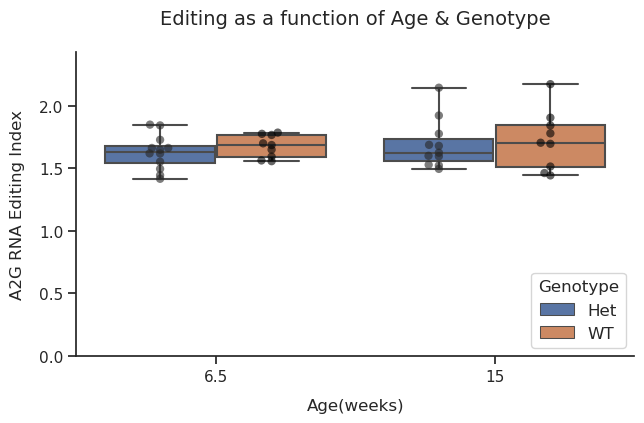

In [46]:
df = signal_noise_df.loc[signal_noise_df["Mismatch"] == "A2G"]
x = "Age(weeks)"
hue = "Genotype"
y = "Index"
x_order = ["6.5", "15"]
hue_order = ["Het", "WT"]
main_title = f"Editing as a function of Age & {hue}"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

### Age & Diet in Males

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

15_Full v.s. 15_Fasted: Custom statistical test, P_val:0.000e+00
6.5_Full v.s. 6.5_Fasted: Custom statistical test, P_val:0.000e+00
6.5_Fasted v.s. 15_Full: Custom statistical test, P_val:0.000e+00
6.5_Full v.s. 15_Full: Custom statistical test, P_val:0.000e+00
6.5_Fasted v.s. 15_Fasted: Custom statistical test, P_val:0.000e+00
6.5_Full v.s. 15_Fasted: Custom statistical test, P_val:0.000e+00



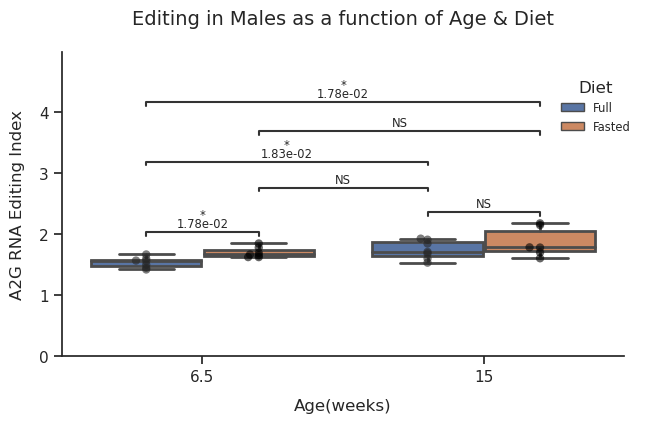

In [47]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & (signal_noise_df["Sex"] == "Male")]
x = "Age(weeks)"
hue = "Diet"
y = "Index"
x_order = ["6.5", "15"]
hue_order = ["Full", "Fasted"]
main_title = f"Editing in Males as a function of Age & {hue}"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

### Age & Genotype in Males

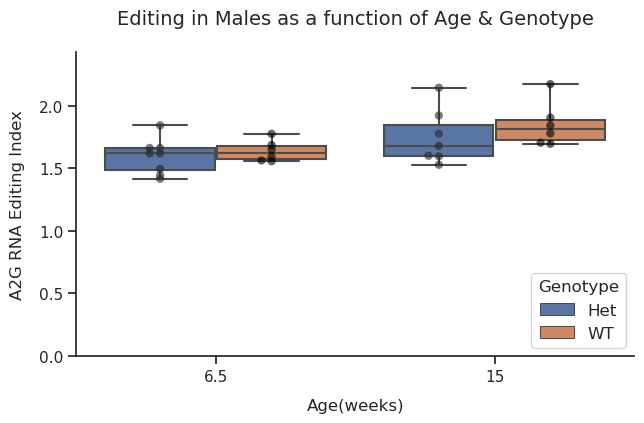

In [48]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & (signal_noise_df["Sex"] == "Male")]
x = "Age(weeks)"
hue = "Genotype"
y = "Index"
x_order = ["6.5", "15"]
hue_order = ["Het", "WT"]
main_title = f"Editing in Males as a function of Age & {hue}"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

### Males: Age

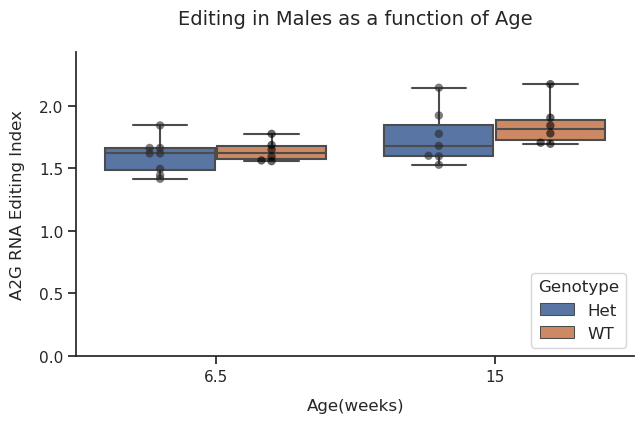

In [49]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Male")]
x = "Age(weeks)"
y = "Index"
hue = "Genotype"
x_order = ["6.5", "15"]
main_title = "Editing in Males as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

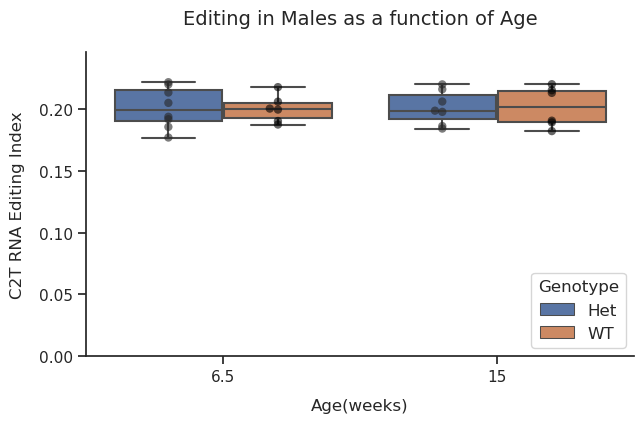

In [50]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="C2T") & 
                         (signal_noise_df["Sex"]=="Male")]
x = "Age(weeks)"
y = "Index"
hue = "Genotype"
x_order = ["6.5", "15"]
main_title = "Editing in Males as a function of Age"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

### Females: Age

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

15_Het v.s. 15_WT: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 6.5_WT: Custom statistical test, P_val:0.000e+00
6.5_WT v.s. 15_Het: Custom statistical test, P_val:0.000e+00
6.5_WT v.s. 15_WT: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 15_Het: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 15_WT: Custom statistical test, P_val:0.000e+00



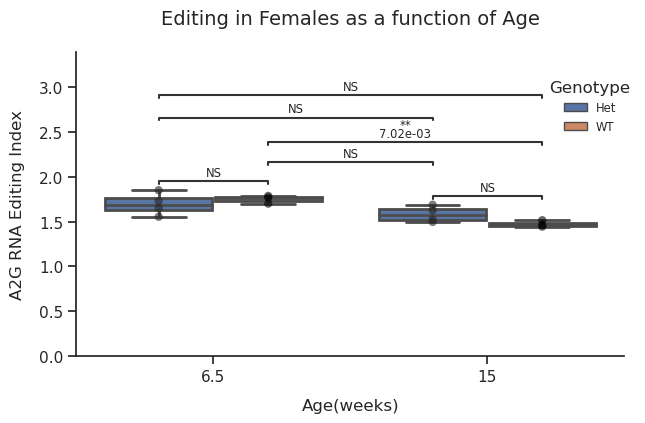

In [51]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Female")]
x = "Age(weeks)"
y = "Index"
hue = "Genotype"
x_order = ["6.5", "15"]
hue_order = ["Het", "WT"]
main_title = "Editing in Females as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True
               )

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

15_Het v.s. 15_WT: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 6.5_WT: Custom statistical test, P_val:0.000e+00
6.5_WT v.s. 15_Het: Custom statistical test, P_val:0.000e+00
6.5_WT v.s. 15_WT: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 15_Het: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 15_WT: Custom statistical test, P_val:0.000e+00



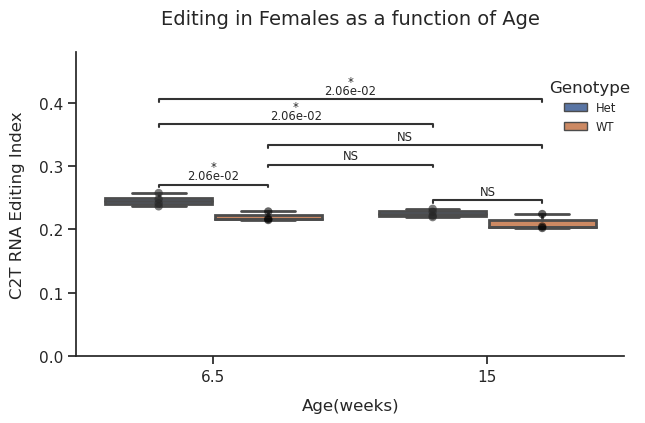

In [52]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="C2T") & 
                         (signal_noise_df["Sex"]=="Female")]
x = "Age(weeks)"
y = "Index"
hue = "Genotype"
x_order = ["6.5", "15"]
hue_order = ["Het", "WT"]
main_title = "Editing in Females as a function of Age"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True
               )

### Females: Genotype

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Het v.s. WT: Custom statistical test, P_val:0.000e+00



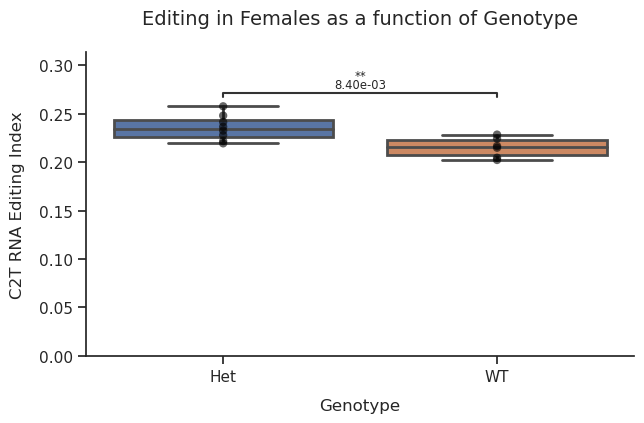

In [53]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="C2T") & 
                         (signal_noise_df["Sex"]=="Female")]
x = "Genotype"
y = "Index"
x_order = ["Het", "WT"]
main_title = "Editing in Females as a function of Genotype"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Het v.s. WT: Custom statistical test, P_val:0.000e+00



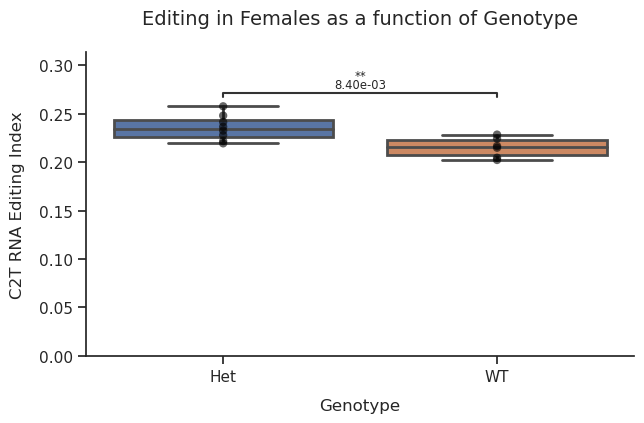

In [54]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="C2T") & 
                         (signal_noise_df["Sex"]=="Female")]
x = "Genotype"
y = "Index"
x_order = ["Het", "WT"]
main_title = "Editing in Females as a function of Genotype"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

### Sex-Diet-Genotype: Young vs Old

#### Male-Fully fed-WT

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

6.5 v.s. 15: Custom statistical test, P_val:0.000e+00



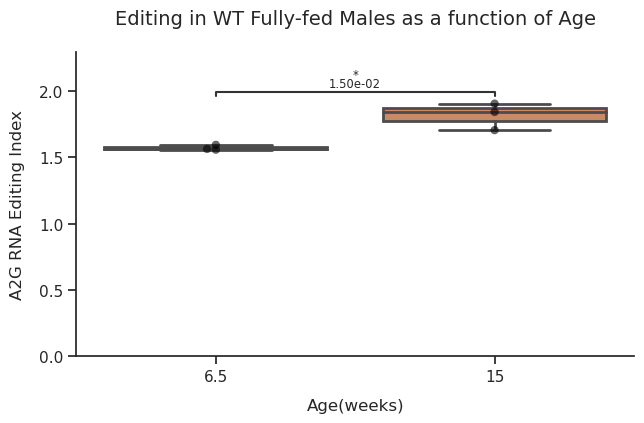

In [55]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Male") & 
                         (signal_noise_df["Diet"]=="Full") & 
                         (signal_noise_df["Genotype"]=="WT")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing in WT Fully-fed Males as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y,  
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

#### Male-Fully fed-Het

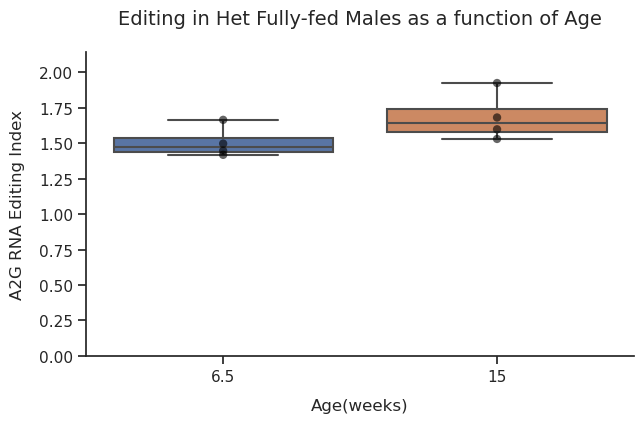

In [56]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Male") & 
                         (signal_noise_df["Diet"]=="Full") & 
                         (signal_noise_df["Genotype"]=="Het")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = f"Editing in Het Fully-fed Males as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

#### Fully fed Males: Age & Genotype

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

15_Het v.s. 15_WT: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 6.5_WT: Custom statistical test, P_val:0.000e+00
6.5_WT v.s. 15_Het: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 15_Het: Custom statistical test, P_val:0.000e+00
6.5_WT v.s. 15_WT: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 15_WT: Custom statistical test, P_val:0.000e+00



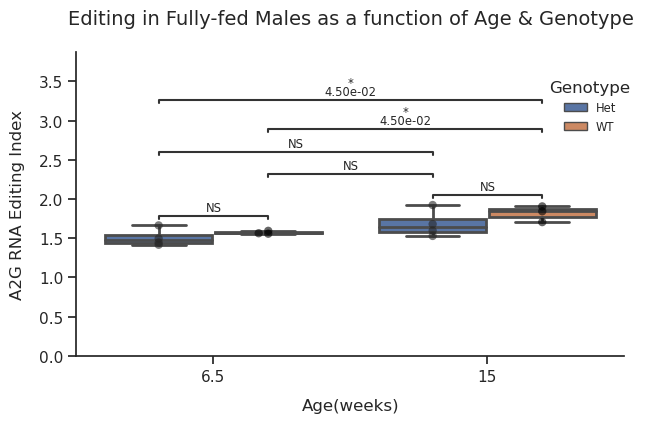

In [57]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G") & 
                         (signal_noise_df["Sex"] == "Male") & 
                         (signal_noise_df["Diet"] == "Full")]
x = "Age(weeks)"
hue = "Genotype"
y = "Index"
x_order = ["6.5", "15"]
hue_order = ["Het", "WT"]
main_title = "Editing in Fully-fed Males as a function of Age & Genotype"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

#### Male-Fasted-WT

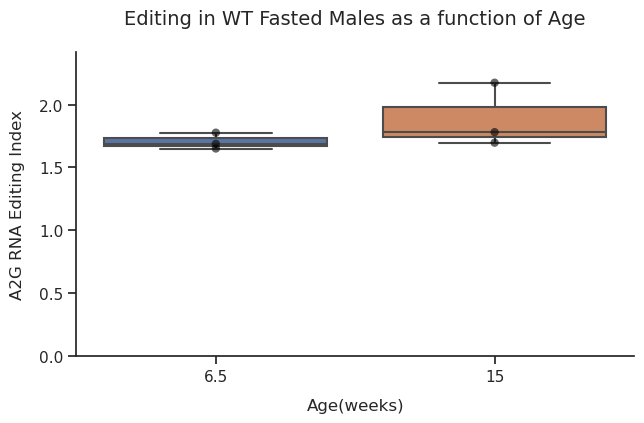

In [58]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Male") & 
                         (signal_noise_df["Diet"]=="Fasted") & 
                         (signal_noise_df["Genotype"]=="WT")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing in WT Fasted Males as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y,  
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

#### Male-Fasted-Het

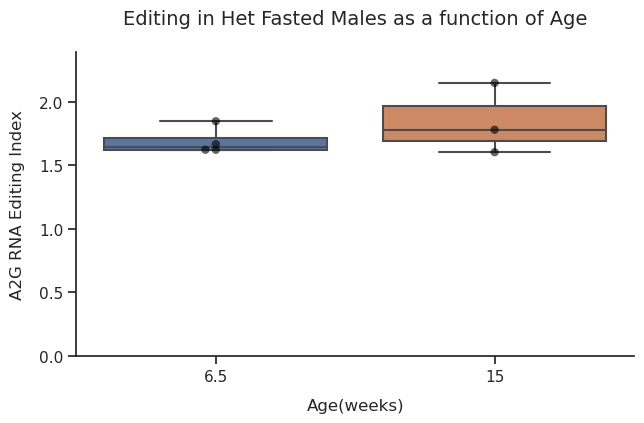

In [59]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Male") & 
                         (signal_noise_df["Diet"]=="Fasted") & 
                         (signal_noise_df["Genotype"]=="Het")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing in Het Fasted Males as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y,  
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

#### Fasted Males: Age & Genotype

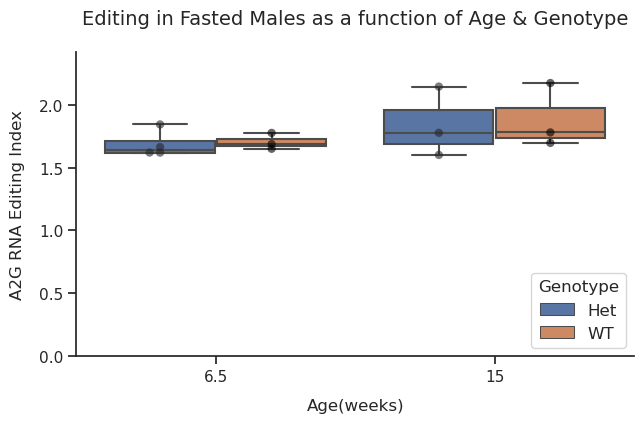

In [60]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G") & 
                         (signal_noise_df["Sex"] == "Male") & 
                         (signal_noise_df["Diet"] == "Fasted")]
x = "Age(weeks)"
hue = "Genotype"
y = "Index"
x_order = ["6.5", "15"]
hue_order = ["Het", "WT"]
main_title = "Editing in Fasted Males as a function of Age & Genotype"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

#### Female-Fasted-WT

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

6.5 v.s. 15: Custom statistical test, P_val:0.000e+00



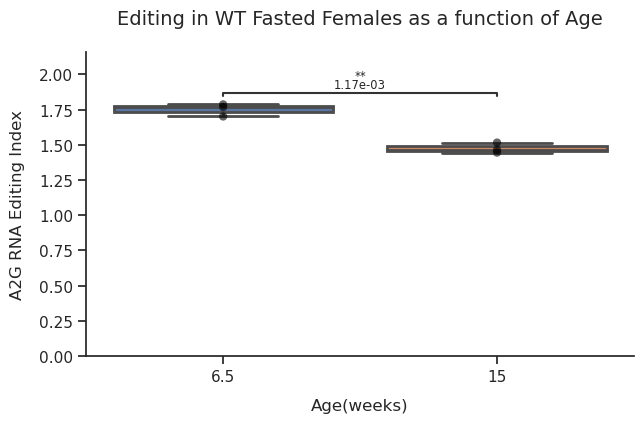

In [61]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Female") & 
                         (signal_noise_df["Diet"]=="Fasted") & 
                         (signal_noise_df["Genotype"]=="WT")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing in WT Fasted Females as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

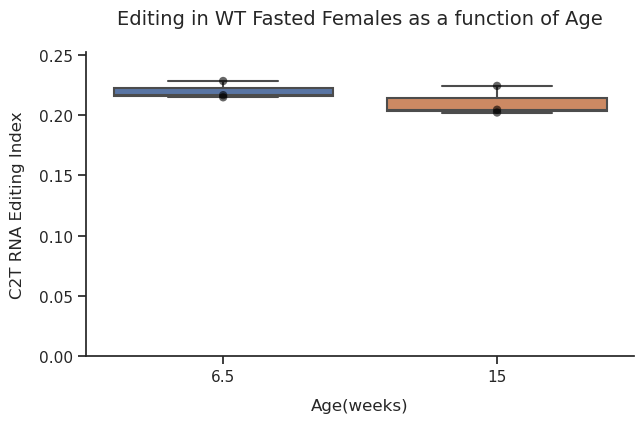

In [62]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="C2T") & 
                         (signal_noise_df["Sex"]=="Female") & 
                         (signal_noise_df["Diet"]=="Fasted") & 
                         (signal_noise_df["Genotype"]=="WT")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing in WT Fasted Females as a function of Age"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

#### Female-Fasted-Het

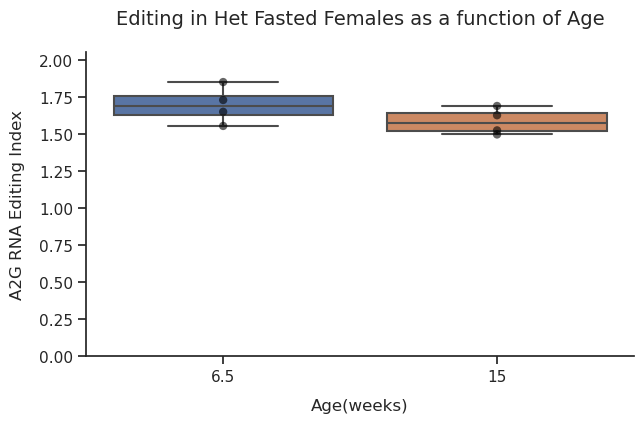

In [63]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="A2G") & 
                         (signal_noise_df["Sex"]=="Female") & 
                         (signal_noise_df["Diet"]=="Fasted") & 
                         (signal_noise_df["Genotype"]=="Het")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing in Het Fasted Females as a function of Age"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

6.5 v.s. 15: Custom statistical test, P_val:0.000e+00



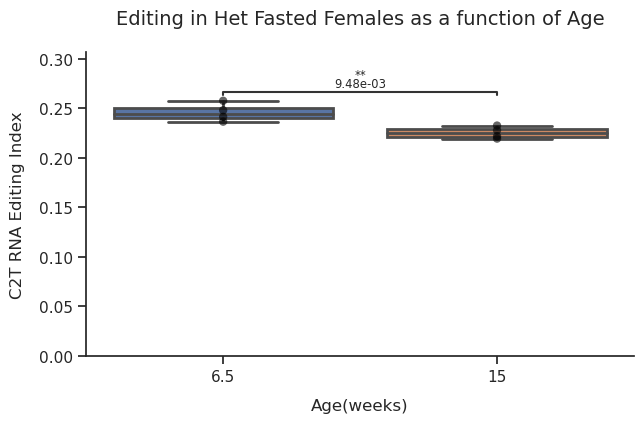

In [64]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"]=="C2T") & 
                         (signal_noise_df["Sex"]=="Female") & 
                         (signal_noise_df["Diet"]=="Fasted") & 
                         (signal_noise_df["Genotype"]=="Het")]
x = "Age(weeks)"
y = "Index"
x_order = ["6.5", "15"]
main_title = "Editing in Het Fasted Females as a function of Age"
ylabel = "C2T RNA Editing Index"
statannot_plot(df, x, y,
               x_order=x_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)

#### Fasted Females: Age & Genotype

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

15_Het v.s. 15_WT: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 6.5_WT: Custom statistical test, P_val:0.000e+00
6.5_WT v.s. 15_Het: Custom statistical test, P_val:0.000e+00
6.5_WT v.s. 15_WT: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 15_Het: Custom statistical test, P_val:0.000e+00
6.5_Het v.s. 15_WT: Custom statistical test, P_val:0.000e+00



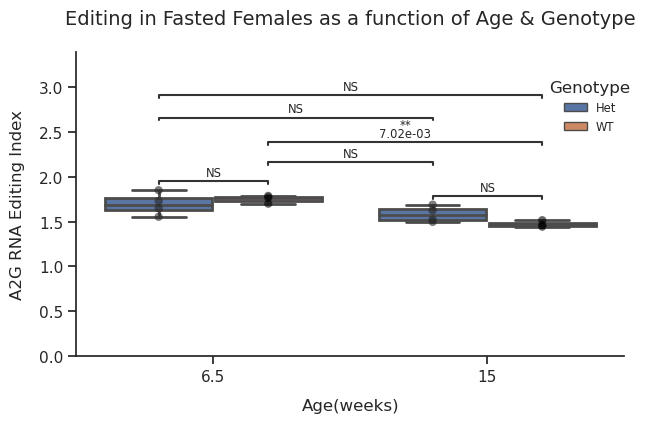

In [65]:
df = signal_noise_df.loc[(signal_noise_df["Mismatch"] == "A2G") & 
                         (signal_noise_df["Sex"] == "Female") & 
                         (signal_noise_df["Diet"] == "Fasted")]
x = "Age(weeks)"
hue = "Genotype"
y = "Index"
x_order = ["6.5", "15"]
hue_order = ["Het", "WT"]
main_title = "Editing in Fasted Females as a function of Age & Genotype"
ylabel = "A2G RNA Editing Index"
statannot_plot(df, x, y, hue=hue, 
               x_order=x_order, hue_order=hue_order,
               main_title=main_title, ylabel=ylabel,
               plots_out_dir=plots_out_dir, dpi=dpi,
               explicit_pvs_and_ns_theme_full_experience=True)